#################################################### Importing Libraries ####################################################

In [1]:
!pip install import_ipynb
!pip install -U -q PyDrive
!pip install pytorch_pretrained_bert
!pip install sparse
!pip install transformers
!pip install torchmetrics
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
2.1.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip

In [2]:
!pip install einops


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat

import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor

from sklearn.model_selection import ShuffleSplit
import pickle
from matplotlib import pyplot as plt
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

/Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_geometric/typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN5torch8autograd13_wrap_outputsERKNSt3__16vectorIN2at6TensorENS1_9allocatorIS4_EEEERKNS1_13unordered_setIPN3c1010TensorImplENS1_4hashISD_EENS1_8equal_toISD_EENS5_ISD_EEEESL_NSB_8ArrayRefINSB_8optionalIS4_EEEERKNS1_10shared_ptrINS0_4NodeEEENS1_8functionIFS7_S7_S7_EEE
  Referenced from: <BEF9F452-9D77-323E-91B8-AF667F303838> /Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue 

#################################################### Start tensorboard ####################################################

In [4]:
# %load_ext tensorboard
# %reload_ext tensorboard
# # %tensorboard --logdir $log_dir --port 6006

#################################################### Defining classes ####################################################

In [5]:
#######################################################################################################################################
###################################################### Transformer Conv ###############################################################
#######################################################################################################################################

class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [6]:
#######################################################################################################################################
###################################################### Graph Transformer ###############################################################
#######################################################################################################################################

class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)
        
        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5) 
        self.embed_ee = nn.Embedding(config.node_attr_size, config.hidden_size // 5)
                    

    def forward(self, x, edge_index, edge_index_readout, edge_attr, batch):
        #print("GT")
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x, h_nodes

In [7]:
#######################################################################################################################################
######################################################## Bert Config ##################################################################
#######################################################################################################################################

class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.type_vocab_size = config.get('type_vocab_size')
        self.time_vocab_size = config.get('time_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')
        self.node_attr_size = config.get('node_attr_size')
        

In [8]:
class Pre_training_1(nn.Module):
    def __init__(self, config):
        super(Pre_training_1, self).__init__()
        self.config = config
        self.gnn = GraphTransformer(config)
        self.linear = nn.Linear(self.config.hidden_size // 5, self.config.vocab_size)
        self.layers = nn.ModuleList([self.gnn, self.linear])

    def forward(self, nodes, edge_index, edge_index_readout, edge_attr, batch):
        # Define the forward pass using self.gnn and self.linear as needed
        vst,x = self.gnn(nodes, edge_index, edge_index_readout, edge_attr, batch)
        x = self.linear(x)
        return x

In [9]:
#######################################################################################################################################
############################################################ GDSet ####################################################################
#######################################################################################################################################

class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

#################################################### Importing Data ######################################################

In [10]:
path = '../../data/'
path_results = '../../results/'

In [11]:
with open(path + 'data_pad100.pkl', 'rb') as handle:
    dataset = pickle.load(handle)

##################################################### Splitting Data ######################################################

In [12]:
#######################################################################################################################################
pourcentage_nodes_to_mask = 0.15
labels_masked_nodes = []
mask_node_embeddings = 2

In [13]:
def split_dataset(dataset, train_params, random_seed=1):
  rs = ShuffleSplit(n_splits=1, test_size=train_params.get('test_split'), random_state=random_seed)

  for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
    rs2 = ShuffleSplit(n_splits=1, test_size=train_params.get('val_split'), random_state=random_seed)
    
    for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
      train_index = train_index_tmp[train_index]
      val_index = train_index_tmp[val_index]
      trainDSet = [dataset[x] for x in train_index]
      valDSet = [dataset[x] for x in val_index]
      testDSet = [dataset[x] for x in test_index]

      return trainDSet, valDSet, testDSet

###################################################### Config Files ######################################################

In [14]:
train_params = {
    'batch_size': 5,
    'max_len_seq': 50,
    #'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"),
    'device': "cpu",
    'data_len' : len(dataset),
    'val_split' : 0.1,
    'test_split' : 0.2,
    'train_data_len' : int(0.9*0.8*len(dataset)),   # the train dataset is 90% of 80% of the whole dataset
    'val_data_len' : int(0.1*0.8*len(dataset)),   # the validation dataset is 10% of 80% of the whole dataset
    'test_data_len' : int(0.2*len(dataset)),   # the test dataset is 20% of the whole dataset
    'epochs' : 15,
    'lr': 0.0001,
    'weight_decay': 0.0001
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding (avec vst) + 1 for mask
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11+1, # number of vocab for type embedding + 1 for mask
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'num_labels':1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

######################################################## CUDA ##########################################################

In [15]:
# print which device is used
print('device: ', train_params['device'])

device:  cpu


#################################################### Training Functions ####################################################

In [16]:
# print(len(vars))
# print(type(vars))
# print(vars[-1].shape)

In [17]:
def train(model, optim, trainload, device, writer, epoch):
    tr_loss = 0
    start = time.time()
    model.train()
    
    CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)
    
    for step, data in tqdm(enumerate(trainload)):
        optim.zero_grad()

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
                
        list_index = [i for i in range(nodes.shape[0])]
        random.shuffle(list_index)
        index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
        index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
        labels_nodes = nodes
        ytrue = nodes

        labels_nodes[index_nodes_not_masked] = 3
        nodes[index_nodes_to_mask] = mask_node_embeddings
        
        edge_index = graph_batch.edge_index
        edge_index_readout = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch

        pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)
        
        loss = CE_loss(pred, labels_nodes)
        # Update TensorBoard for train loss per iteration
        writer.add_scalar('Train Loss per Iteration', loss.item(), epoch * len(trainload) + step)
        
        loss.backward()
        tr_loss += loss.item()
        optim.step()

        del loss

    print("TOTAL TRAIN LOSS", (tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    
    # Update TensorBoard for total train loss per epoch
    writer.add_scalar('Total Train Loss per Epoch', (tr_loss * train_params['batch_size']) / len(trainload), epoch)
    
    return tr_loss, cost, pred,ytrue

In [18]:
def eval(model, _valload, device, writer, epoch):
    tr_loss = 0
    start = time.time()
    model.eval()
    CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)
    
    with torch.no_grad():
        for step, data in tqdm(enumerate(_valload)):
            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
                    
            list_index = [i for i in range(nodes.shape[0])]
            random.shuffle(list_index)
            index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
            index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
            labels_nodes = nodes
            ytrue = nodes
            
            labels_nodes[index_nodes_not_masked] = 3
            nodes[index_nodes_to_mask] = mask_node_embeddings
            
            edge_index = graph_batch.edge_index
            edge_index_readout = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch

            pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)

            loss = CE_loss(pred, labels_nodes)
            # Update TensorBoard for eval loss per iteration
            writer.add_scalar('Eval Loss per Iteration', loss.item(), epoch * len(_valload) + step)
            
            tr_loss += loss.item()
            
            del loss

    print("TOTAL EVAL LOSS", (tr_loss * train_params['batch_size']) / len(_valload))
    
    # Update TensorBoard for total eval loss per epoch
    writer.add_scalar('Total Eval Loss per Epoch', (tr_loss * train_params['batch_size']) / len(_valload), epoch)
    
    cost = time.time() - start
    return tr_loss, cost, pred, ytrue

In [19]:
def run_epoch(model, optim_model, trainload, valload, device, exp, writer):
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []
    
    for e in tqdm(range(train_params["epochs"])):
        print("Epoch n" + str(e))
        train_loss, train_time_cost, pred_train, ytrue_train = train(model, optim_model, trainload, device, writer, e)
        val_loss, val_time_cost, pred_eval, ytrue_eval = eval(model, valload, device, writer, e)
        accuracy_train = skm.accuracy_score(ytrue_train.cpu().detach().numpy(), pred_train.cpu().detach().numpy().argmax(axis=1))
        accuracy_eval = skm.accuracy_score(ytrue_eval.cpu().detach().numpy(), pred_eval.cpu().detach().numpy().argmax(axis=1))

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        print('TRAIN \t{} secs'.format(train_time_cost))
        print(f'TRAIN accuracy : {accuracy_train}')
        
        with open(path_results + 'losses_and_times/' + "pre_training_1_log_train_" + f'{exp}' + ".txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')
        print('EVAL \t{} secs'.format(val_time_cost))
        print('EVAL accuracy : {}\n\n'.format(accuracy_eval))
        
        # ... (your existing code)

        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            torch.save(model.gnn.state_dict(), path_results + 'weights/' + 'GraphTransformer_pretrain_1_num_' + f'{exp}' + '.pch')
            best_val = val_loss
            
    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(path_results + 'plots/' + 'Pre_training_1.png')
    plt.show()

    return train_loss, val_loss, accuracy_train, accuracy_eval, train_time_cost, val_time_cost

################################################### Experiences ####################################################

In [20]:
def experiment(num_experiments=5):
    conf = BertConfig(model_config)
    df = pd.DataFrame(columns=['Experiment', 'Model', 'Metric', 'Score'])

    for exp in tqdm(range(num_experiments)):
        model = Pre_training_1(conf).to(train_params['device'])
        transformer_vars = [i for i in model.parameters()]
        optim_model = torch.optim.AdamW(transformer_vars, lr=train_params['lr'], weight_decay=train_params['weight_decay'])

        # Set log directory for TensorBoard
        writer = SummaryWriter(path_results + 'runs/' + 'pre_training_1/' + str(exp + 1))


        print(f"\n Experiment {exp + 1}")
        trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=exp)
        trainload = GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False)
        valload = GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)

        train_loss, val_loss, accuracy_train, accuracy_eval, train_time_cost, val_time_cost = run_epoch(
            model, optim_model, trainload, valload, train_params['device'], exp, writer
        )

        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Accuracy', accuracy_eval]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Loss', train_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Loss', val_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Time', train_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Time', val_time_cost]

        # Close the writer for the current experiment
        writer.close()

    df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_1.csv')

    return df

######################################################## Main #########################################################

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]

1it [00:00,  8.48it/s]


 Experiment 1
Epoch n0




3it [00:00,  9.52it/s]

5it [00:00, 10.84it/s]

7it [00:00, 11.35it/s]

9it [00:00, 12.29it/s]

11it [00:00, 11.27it/s]

13it [00:01, 12.04it/s]

15it [00:01, 12.94it/s]


2it [00:00, 50.12it/s][A

  7%|▋         | 1/15 [00:01<00:16,  1.21s/it]

0it [00:00, ?it/s]

2it [00:00, 15.11it/s]

TOTAL TRAIN LOSS 45.29020150502523
TOTAL EVAL LOSS 42.65822887420654
TRAIN 	1.1603326797485352 secs
TRAIN accuracy : 0.0010976948408342481
EVAL 	0.041108131408691406 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 15.04it/s]

6it [00:00, 15.16it/s]

8it [00:00, 14.79it/s]

10it [00:00, 13.00it/s]

12it [00:00, 14.41it/s]

15it [00:01, 14.37it/s]


2it [00:00, 49.51it/s][A

 13%|█▎        | 2/15 [00:02<00:15,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 14.47it/s]

TOTAL TRAIN LOSS 39.98775657018026
TOTAL EVAL LOSS 38.21118116378784
TRAIN 	1.0446500778198242 secs
TRAIN accuracy : 0.06366630076838639
EVAL 	0.041628122329711914 secs
EVAL accuracy : 0.035940803382663845


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 14.47it/s]

6it [00:00, 14.64it/s]

8it [00:00, 14.49it/s]

10it [00:00, 12.97it/s]

13it [00:00, 14.17it/s]

15it [00:01, 14.60it/s]


2it [00:00, 51.72it/s][A

 20%|██        | 3/15 [00:03<00:13,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 15.26it/s]

TOTAL TRAIN LOSS 34.796333471934
TOTAL EVAL LOSS 30.978626012802124
TRAIN 	1.0282249450683594 secs
TRAIN accuracy : 0.12294182217343579
EVAL 	0.03963208198547363 secs
EVAL accuracy : 0.10570824524312897


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 15.36it/s]

6it [00:00, 15.29it/s]

8it [00:00, 14.21it/s]

10it [00:00, 12.59it/s]

12it [00:00, 13.92it/s]

15it [00:01, 14.21it/s]


2it [00:00, 49.23it/s][A

 27%|██▋       | 4/15 [00:04<00:12,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 14.37it/s]

TOTAL TRAIN LOSS 28.764902750651043
TOTAL EVAL LOSS 24.864553213119507
TRAIN 	1.0566580295562744 secs
TRAIN accuracy : 0.12623490669593854
EVAL 	0.04154491424560547 secs
EVAL accuracy : 0.10993657505285412


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 14.42it/s]

6it [00:00, 14.62it/s]

8it [00:00, 14.37it/s]

10it [00:00, 12.74it/s]

12it [00:00, 14.18it/s]

15it [00:01, 14.25it/s]


2it [00:00, 50.82it/s][A

 33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 14.27it/s]

TOTAL TRAIN LOSS 21.995314836502075
TOTAL EVAL LOSS 19.056379199028015
TRAIN 	1.0539169311523438 secs
TRAIN accuracy : 0.12843029637760703
EVAL 	0.040376901626586914 secs
EVAL accuracy : 0.10782241014799154


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 14.35it/s]

6it [00:00, 14.50it/s]

8it [00:00, 14.13it/s]

10it [00:00, 12.52it/s]

12it [00:00, 13.82it/s]

15it [00:01, 14.04it/s]


2it [00:00, 49.86it/s][A

 40%|████      | 6/15 [00:06<00:10,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 14.09it/s]

TOTAL TRAIN LOSS 16.14639953772227
TOTAL EVAL LOSS 15.069846510887146
TRAIN 	1.0692529678344727 secs
TRAIN accuracy : 0.13391877058177826
EVAL 	0.04191398620605469 secs
EVAL accuracy : 0.09725158562367865


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 14.07it/s]

6it [00:00, 14.09it/s]

8it [00:00, 13.63it/s]

10it [00:00, 11.89it/s]

12it [00:00, 12.71it/s]

15it [00:01, 13.07it/s]


2it [00:00, 44.18it/s][A

 47%|████▋     | 7/15 [00:07<00:09,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 14.23it/s]

TOTAL TRAIN LOSS 13.192330002784729
TOTAL EVAL LOSS 13.9601069688797
TRAIN 	1.1489238739013672 secs
TRAIN accuracy : 0.13172338090010977
EVAL 	0.04647970199584961 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 14.34it/s]

6it [00:00, 14.49it/s]

8it [00:00, 14.15it/s]

10it [00:00, 12.47it/s]

12it [00:00, 13.87it/s]

15it [00:01, 13.97it/s]


2it [00:00, 50.33it/s][A

 53%|█████▎    | 8/15 [00:09<00:07,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 14.40it/s]

TOTAL TRAIN LOSS 10.563391923904419
TOTAL EVAL LOSS 12.906854152679443
TRAIN 	1.0746691226959229 secs
TRAIN accuracy : 0.1394072447859495
EVAL 	0.04083514213562012 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 14.49it/s]

6it [00:00, 14.60it/s]

8it [00:00, 14.22it/s]

10it [00:00, 12.60it/s]

12it [00:00, 14.02it/s]

15it [00:01, 14.11it/s]


2it [00:00, 49.12it/s][A

 60%|██████    | 9/15 [00:10<00:06,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 14.58it/s]

TOTAL TRAIN LOSS 9.951468686262766
TOTAL EVAL LOSS 9.785663485527039
TRAIN 	1.0643420219421387 secs
TRAIN accuracy : 0.14818880351262348
EVAL 	0.04179096221923828 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 14.42it/s]

6it [00:00, 14.37it/s]

8it [00:00, 14.09it/s]

10it [00:00, 12.41it/s]

12it [00:00, 13.80it/s]

15it [00:01, 13.92it/s]


2it [00:00, 45.76it/s][A

 67%|██████▋   | 10/15 [00:11<00:05,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 14.50it/s]

TOTAL TRAIN LOSS 8.816805283228556
TOTAL EVAL LOSS 8.850778639316559
TRAIN 	1.0790607929229736 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.044747114181518555 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n10




4it [00:00, 14.42it/s]

6it [00:00, 14.57it/s]

8it [00:00, 14.16it/s]

10it [00:00, 12.61it/s]

12it [00:00, 13.97it/s]

15it [00:01, 14.04it/s]


2it [00:00, 48.30it/s][A

 73%|███████▎  | 11/15 [00:12<00:04,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 14.42it/s]

TOTAL TRAIN LOSS 7.907004038492839
TOTAL EVAL LOSS 7.104201316833496
TRAIN 	1.069901943206787 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.04245185852050781 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n11




4it [00:00, 14.44it/s]

6it [00:00, 14.59it/s]

8it [00:00, 14.23it/s]

10it [00:00, 12.55it/s]

12it [00:00, 13.88it/s]

15it [00:01, 14.02it/s]


2it [00:00, 47.64it/s][A

 80%|████████  | 12/15 [00:13<00:03,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 14.50it/s]

TOTAL TRAIN LOSS 6.677627931038539
TOTAL EVAL LOSS 6.085534989833832
TRAIN 	1.0710132122039795 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.04308795928955078 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 14.40it/s]

6it [00:00, 14.48it/s]

8it [00:00, 14.14it/s]

10it [00:00, 12.59it/s]

12it [00:00, 13.91it/s]

15it [00:01, 13.96it/s]


2it [00:00, 47.81it/s][A

 87%|████████▋ | 13/15 [00:14<00:02,  1.13s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 5.08265499273936
TOTAL EVAL LOSS 4.715603739023209
TRAIN 	1.0752778053283691 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.04285788536071777 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n13




2it [00:00, 12.95it/s]

4it [00:00, 12.91it/s]

6it [00:00, 13.09it/s]

8it [00:00, 12.82it/s]

10it [00:00, 11.76it/s]

12it [00:00, 13.22it/s]

15it [00:01, 13.27it/s]


2it [00:00, 47.71it/s][A

 93%|█████████▎| 14/15 [00:15<00:01,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 14.58it/s]

TOTAL TRAIN LOSS 3.4580709089835486
TOTAL EVAL LOSS 1.4437481760978699
TRAIN 	1.1312999725341797 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.04297304153442383 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 14.46it/s]

6it [00:00, 14.54it/s]

8it [00:00, 14.15it/s]

10it [00:00, 12.60it/s]

12it [00:00, 13.89it/s]

15it [00:01, 13.97it/s]


2it [00:00, 45.26it/s][A

100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


TOTAL TRAIN LOSS 1.60246042907238
TOTAL EVAL LOSS 0.22742676548659801
TRAIN 	1.07442307472229 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.04520392417907715 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 


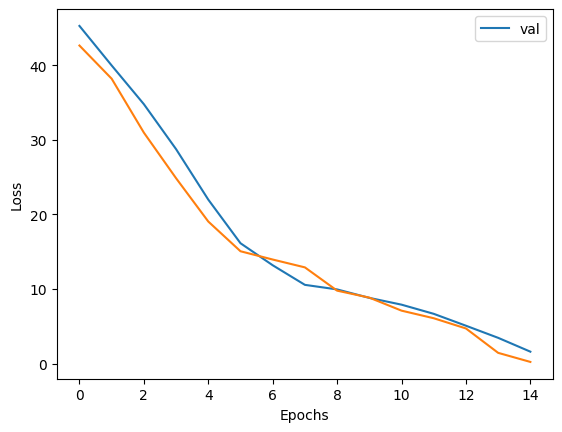

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 2
Epoch n0




1it [00:00,  7.56it/s]

3it [00:00,  8.58it/s]

5it [00:00,  9.66it/s]

7it [00:00, 10.57it/s]

9it [00:00, 10.17it/s]

11it [00:00, 11.14it/s]

15it [00:01, 12.91it/s]


2it [00:00, 47.33it/s][A

  7%|▋         | 1/15 [00:01<00:16,  1.21s/it]

0it [00:00, ?it/s]

2it [00:00, 16.48it/s]

TOTAL TRAIN LOSS 47.32763163248698
TOTAL EVAL LOSS 45.06115674972534
TRAIN 	1.16432523727417 secs
TRAIN accuracy : 0.0
EVAL 	0.043710947036743164 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 16.55it/s]

6it [00:00, 15.67it/s]

8it [00:00, 15.83it/s]

10it [00:00, 13.05it/s]

12it [00:00, 13.30it/s]

15it [00:01, 14.69it/s]


2it [00:00, 42.60it/s][A

 13%|█▎        | 2/15 [00:02<00:15,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 16.19it/s]

TOTAL TRAIN LOSS 43.019598960876465
TOTAL EVAL LOSS 40.60549736022949
TRAIN 	1.0222408771514893 secs
TRAIN accuracy : 0.0
EVAL 	0.04787898063659668 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 16.27it/s]

6it [00:00, 15.50it/s]

8it [00:00, 15.77it/s]

10it [00:00, 13.13it/s]

12it [00:00, 13.41it/s]

15it [00:01, 14.78it/s]


2it [00:00, 43.15it/s][A

 20%|██        | 3/15 [00:03<00:13,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 16.03it/s]

TOTAL TRAIN LOSS 38.498351414998375
TOTAL EVAL LOSS 35.964823961257935
TRAIN 	1.0161690711975098 secs
TRAIN accuracy : 0.03299492385786802
EVAL 	0.04746413230895996 secs
EVAL accuracy : 0.060218978102189784


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 16.33it/s]

6it [00:00, 15.30it/s]

8it [00:00, 15.52it/s]

10it [00:00, 13.04it/s]

12it [00:00, 13.40it/s]

15it [00:01, 14.75it/s]


2it [00:00, 44.42it/s][A

 27%|██▋       | 4/15 [00:04<00:12,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 16.72it/s]

TOTAL TRAIN LOSS 33.11921167373657
TOTAL EVAL LOSS 29.695979356765747
TRAIN 	1.018531084060669 secs
TRAIN accuracy : 0.10406091370558376
EVAL 	0.04601097106933594 secs
EVAL accuracy : 0.11131386861313869


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 16.78it/s]

6it [00:00, 15.68it/s]

8it [00:00, 15.94it/s]

10it [00:00, 13.14it/s]

12it [00:00, 13.39it/s]

15it [00:01, 14.82it/s]


2it [00:00, 44.90it/s][A

 33%|███▎      | 5/15 [00:05<00:11,  1.10s/it]

0it [00:00, ?it/s]

2it [00:00, 16.29it/s]

TOTAL TRAIN LOSS 27.235926151275635
TOTAL EVAL LOSS 24.240858554840088
TRAIN 	1.0135009288787842 secs
TRAIN accuracy : 0.1065989847715736
EVAL 	0.04572725296020508 secs
EVAL accuracy : 0.10218978102189781


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 16.38it/s]

6it [00:00, 15.55it/s]

8it [00:00, 15.67it/s]

10it [00:00, 13.10it/s]

12it [00:00, 13.41it/s]

15it [00:01, 14.78it/s]


2it [00:00, 41.54it/s][A

 40%|████      | 6/15 [00:06<00:09,  1.09s/it]

0it [00:00, ?it/s]

2it [00:00, 16.38it/s]

TOTAL TRAIN LOSS 20.171891848246258
TOTAL EVAL LOSS 17.233073115348816
TRAIN 	1.016108751296997 secs
TRAIN accuracy : 0.116751269035533
EVAL 	0.04914999008178711 secs
EVAL accuracy : 0.10583941605839416


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 16.30it/s]

6it [00:00, 15.34it/s]

8it [00:00, 15.45it/s]

10it [00:00, 12.94it/s]

12it [00:00, 13.30it/s]

15it [00:01, 14.63it/s]


2it [00:00, 44.41it/s][A

 47%|████▋     | 7/15 [00:07<00:08,  1.09s/it]

0it [00:00, ?it/s]

2it [00:00, 15.22it/s]

TOTAL TRAIN LOSS 14.96328604221344
TOTAL EVAL LOSS 12.088613510131836
TRAIN 	1.02656888961792 secs
TRAIN accuracy : 0.11928934010152284
EVAL 	0.04606223106384277 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 15.56it/s]

6it [00:00, 15.07it/s]

8it [00:00, 15.44it/s]

10it [00:00, 13.01it/s]

12it [00:00, 13.37it/s]

15it [00:01, 14.70it/s]


2it [00:00, 47.52it/s][A

 53%|█████▎    | 8/15 [00:08<00:07,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 16.49it/s]

TOTAL TRAIN LOSS 11.756239811579386
TOTAL EVAL LOSS 12.261991500854492
TRAIN 	1.0212280750274658 secs
TRAIN accuracy : 0.12944162436548223
EVAL 	0.04320693016052246 secs
EVAL accuracy : 0.14963503649635038


Epoch n8




4it [00:00, 16.68it/s]

6it [00:00, 15.84it/s]

8it [00:00, 15.94it/s]

10it [00:00, 13.16it/s]

12it [00:00, 13.40it/s]

15it [00:01, 14.82it/s]


2it [00:00, 46.98it/s][A

 60%|██████    | 9/15 [00:09<00:06,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 15.78it/s]

TOTAL TRAIN LOSS 9.977184772491455
TOTAL EVAL LOSS 8.444171249866486
TRAIN 	1.0130021572113037 secs
TRAIN accuracy : 0.14720812182741116
EVAL 	0.04369401931762695 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 16.00it/s]

6it [00:00, 15.23it/s]

8it [00:00, 15.47it/s]

10it [00:00, 12.91it/s]

12it [00:00, 13.28it/s]

15it [00:01, 14.65it/s]


2it [00:00, 47.78it/s][A

 67%|██████▋   | 10/15 [00:10<00:05,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 16.21it/s]

TOTAL TRAIN LOSS 8.991881569226583
TOTAL EVAL LOSS 9.776853621006012
TRAIN 	1.0253231525421143 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.0429229736328125 secs
EVAL accuracy : 0.14963503649635038


Epoch n10




4it [00:00, 16.41it/s]

6it [00:00, 15.55it/s]

8it [00:00, 15.82it/s]

10it [00:00, 13.12it/s]

12it [00:00, 13.23it/s]

15it [00:01, 14.72it/s]


2it [00:00, 48.26it/s][A

 73%|███████▎  | 11/15 [00:11<00:04,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 14.35it/s]

TOTAL TRAIN LOSS 7.358186145623525
TOTAL EVAL LOSS 5.89834988117218
TRAIN 	1.0204651355743408 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04238390922546387 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n11




4it [00:00, 14.67it/s]

6it [00:00, 14.40it/s]

8it [00:00, 14.54it/s]

10it [00:00, 12.21it/s]

12it [00:00, 12.40it/s]

15it [00:01, 13.68it/s]


2it [00:00, 40.74it/s][A

 80%|████████  | 12/15 [00:13<00:03,  1.10s/it]

0it [00:00, ?it/s]

2it [00:00, 15.14it/s]

TOTAL TRAIN LOSS 5.875433643658956
TOTAL EVAL LOSS 4.323466867208481
TRAIN 	1.0979328155517578 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.05023908615112305 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 15.30it/s]

6it [00:00, 14.41it/s]

8it [00:00, 14.47it/s]

10it [00:00, 12.19it/s]

12it [00:00, 12.34it/s]

15it [00:01, 13.57it/s]


2it [00:00, 38.50it/s][A

 87%|████████▋ | 13/15 [00:14<00:02,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 14.65it/s]

TOTAL TRAIN LOSS 3.571419099966685
TOTAL EVAL LOSS 1.5709593892097473
TRAIN 	1.1065211296081543 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.0531461238861084 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n13




4it [00:00, 14.36it/s]

6it [00:00, 13.72it/s]

8it [00:00, 13.92it/s]

10it [00:00, 11.96it/s]

12it [00:00, 12.23it/s]

15it [00:01, 13.30it/s]


2it [00:00, 42.42it/s][A

 93%|█████████▎| 14/15 [00:15<00:01,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 14.62it/s]

TOTAL TRAIN LOSS 1.6035562654336293
TOTAL EVAL LOSS 0.178610198199749
TRAIN 	1.1286602020263672 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.0484309196472168 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 14.61it/s]

6it [00:00, 13.95it/s]

8it [00:00, 14.21it/s]

10it [00:00, 12.07it/s]

12it [00:00, 12.31it/s]

15it [00:01, 13.67it/s]


2it [00:00, 47.53it/s][A

100%|██████████| 15/15 [00:16<00:00,  1.10s/it]

TOTAL TRAIN LOSS 0.615337036550045
TOTAL EVAL LOSS 0.02964142942801118
TRAIN 	1.098616123199463 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04326987266540527 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 


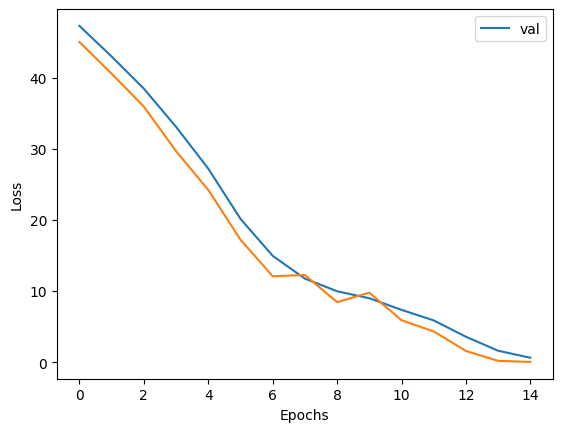

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 3
Epoch n0




2it [00:00, 13.91it/s]

4it [00:00, 12.78it/s]

6it [00:00, 13.52it/s]

8it [00:00, 14.04it/s]

10it [00:00, 13.34it/s]

12it [00:00, 13.76it/s]

15it [00:01, 13.96it/s]


2it [00:00, 44.70it/s][A

  7%|▋         | 1/15 [00:01<00:15,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 17.86it/s]

TOTAL TRAIN LOSS 45.35800552368164
TOTAL EVAL LOSS 42.86589860916138
TRAIN 	1.0761139392852783 secs
TRAIN accuracy : 0.0
EVAL 	0.046003103256225586 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 14.68it/s]

6it [00:00, 14.91it/s]

8it [00:00, 15.27it/s]

10it [00:00, 14.10it/s]

12it [00:00, 14.31it/s]

15it [00:01, 14.16it/s]


2it [00:00, 39.54it/s][A

 13%|█▎        | 2/15 [00:02<00:14,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 17.22it/s]

TOTAL TRAIN LOSS 41.36215957005819
TOTAL EVAL LOSS 39.07206058502197
TRAIN 	1.0605907440185547 secs
TRAIN accuracy : 0.0
EVAL 	0.05190300941467285 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 14.88it/s]

6it [00:00, 15.24it/s]

8it [00:00, 15.49it/s]

10it [00:00, 14.15it/s]

12it [00:00, 14.48it/s]

15it [00:01, 14.54it/s]


2it [00:00, 42.19it/s][A

 20%|██        | 3/15 [00:03<00:13,  1.11s/it]

0it [00:00, ?it/s]

2it [00:00, 15.62it/s]

TOTAL TRAIN LOSS 37.50322103500366
TOTAL EVAL LOSS 34.84133839607239
TRAIN 	1.032677173614502 secs
TRAIN accuracy : 0.046753246753246755
EVAL 	0.04840707778930664 secs
EVAL accuracy : 0.10774410774410774


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 13.87it/s]

6it [00:00, 14.01it/s]

8it [00:00, 14.29it/s]

10it [00:00, 13.00it/s]

12it [00:00, 13.29it/s]

15it [00:01, 13.39it/s]


2it [00:00, 33.04it/s][A

 27%|██▋       | 4/15 [00:04<00:12,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 16.05it/s]

TOTAL TRAIN LOSS 33.68971347808838
TOTAL EVAL LOSS 31.020792722702026
TRAIN 	1.12172269821167 secs
TRAIN accuracy : 0.08051948051948052
EVAL 	0.0617368221282959 secs
EVAL accuracy : 0.10606060606060606


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 14.14it/s]

6it [00:00, 14.95it/s]

8it [00:00, 15.45it/s]

10it [00:00, 14.09it/s]

12it [00:00, 14.54it/s]

15it [00:01, 14.61it/s]


2it [00:00, 43.51it/s][A

 33%|███▎      | 5/15 [00:05<00:11,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 17.83it/s]

TOTAL TRAIN LOSS 28.47941319147746
TOTAL EVAL LOSS 26.41552448272705
TRAIN 	1.0275921821594238 secs
TRAIN accuracy : 0.11688311688311688
EVAL 	0.04708504676818848 secs
EVAL accuracy : 0.1111111111111111


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 15.38it/s]

6it [00:00, 15.90it/s]

8it [00:00, 16.17it/s]

10it [00:00, 14.58it/s]

12it [00:00, 14.81it/s]

15it [00:01, 14.87it/s]


2it [00:00, 42.90it/s][A

 40%|████      | 6/15 [00:06<00:09,  1.10s/it]

0it [00:00, ?it/s]

2it [00:00, 17.73it/s]

TOTAL TRAIN LOSS 23.705488602320354
TOTAL EVAL LOSS 19.714955687522888
TRAIN 	1.0101029872894287 secs
TRAIN accuracy : 0.11428571428571428
EVAL 	0.04760408401489258 secs
EVAL accuracy : 0.10606060606060606


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 15.25it/s]

6it [00:00, 15.83it/s]

8it [00:00, 16.06it/s]

10it [00:00, 14.47it/s]

12it [00:00, 14.83it/s]

15it [00:01, 14.91it/s]


2it [00:00, 45.04it/s][A

 47%|████▋     | 7/15 [00:07<00:08,  1.09s/it]

0it [00:00, ?it/s]

2it [00:00, 17.64it/s]

TOTAL TRAIN LOSS 18.1732550462087
TOTAL EVAL LOSS 15.614044666290283
TRAIN 	1.0073888301849365 secs
TRAIN accuracy : 0.12207792207792208
EVAL 	0.04555702209472656 secs
EVAL accuracy : 0.10437710437710437


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 15.25it/s]

6it [00:00, 15.78it/s]

8it [00:00, 16.07it/s]

10it [00:00, 14.46it/s]

12it [00:00, 14.50it/s]

15it [00:01, 14.46it/s]


2it [00:00, 35.36it/s][A

 53%|█████▎    | 8/15 [00:08<00:07,  1.09s/it]

0it [00:00, ?it/s]

2it [00:00, 15.78it/s]

TOTAL TRAIN LOSS 13.34826103846232
TOTAL EVAL LOSS 11.834491491317749
TRAIN 	1.038133144378662 secs
TRAIN accuracy : 0.12987012987012986
EVAL 	0.057576894760131836 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 13.86it/s]

6it [00:00, 14.16it/s]

8it [00:00, 14.44it/s]

10it [00:00, 13.21it/s]

12it [00:00, 13.68it/s]

15it [00:01, 13.58it/s]


2it [00:00, 34.07it/s][A

 60%|██████    | 9/15 [00:10<00:06,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 15.66it/s]

TOTAL TRAIN LOSS 11.637500802675882
TOTAL EVAL LOSS 11.231973767280579
TRAIN 	1.1056978702545166 secs
TRAIN accuracy : 0.14545454545454545
EVAL 	0.059686899185180664 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 13.76it/s]

6it [00:00, 14.04it/s]

8it [00:00, 14.32it/s]

10it [00:00, 13.09it/s]

12it [00:00, 13.30it/s]

15it [00:01, 13.66it/s]


2it [00:00, 41.57it/s][A

 67%|██████▋   | 10/15 [00:11<00:05,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 18.18it/s]

TOTAL TRAIN LOSS 10.390425523122152
TOTAL EVAL LOSS 11.145139038562775
TRAIN 	1.0989360809326172 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.04930520057678223 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n10




4it [00:00, 15.51it/s]

6it [00:00, 15.83it/s]

8it [00:00, 16.10it/s]

10it [00:00, 14.43it/s]

12it [00:00, 14.91it/s]

15it [00:01, 14.99it/s]


2it [00:00, 44.70it/s][A

 73%|███████▎  | 11/15 [00:12<00:04,  1.11s/it]

0it [00:00, ?it/s]

2it [00:00, 17.72it/s]

TOTAL TRAIN LOSS 9.58072833220164
TOTAL EVAL LOSS 8.596044480800629
TRAIN 	1.0015571117401123 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.045729875564575195 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n11




4it [00:00, 15.55it/s]

6it [00:00, 16.11it/s]

8it [00:00, 16.36it/s]

10it [00:00, 14.82it/s]

12it [00:00, 15.33it/s]

15it [00:00, 15.39it/s]


2it [00:00, 43.31it/s][A

 80%|████████  | 12/15 [00:13<00:03,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 18.95it/s]

TOTAL TRAIN LOSS 8.378125150998434
TOTAL EVAL LOSS 7.65130341053009
TRAIN 	0.9758362770080566 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.04742598533630371 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 16.21it/s]

6it [00:00, 16.50it/s]

8it [00:00, 16.65it/s]

10it [00:00, 15.03it/s]

12it [00:00, 15.26it/s]

15it [00:00, 15.42it/s]


2it [00:00, 42.27it/s][A

 87%|████████▋ | 13/15 [00:14<00:02,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 16.35it/s]

TOTAL TRAIN LOSS 7.901471376419067
TOTAL EVAL LOSS 7.2298747301101685
TRAIN 	0.9733750820159912 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.048497915267944336 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n13




4it [00:00, 14.47it/s]

6it [00:00, 14.89it/s]

8it [00:00, 15.50it/s]

10it [00:00, 13.74it/s]

12it [00:00, 13.92it/s]

15it [00:01, 14.09it/s]


2it [00:00, 38.88it/s][A

 93%|█████████▎| 14/15 [00:15<00:01,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 16.01it/s]

TOTAL TRAIN LOSS 6.548569619655609
TOTAL EVAL LOSS 5.996672511100769
TRAIN 	1.065953016281128 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.05236005783081055 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 14.24it/s]

6it [00:00, 14.53it/s]

8it [00:00, 14.71it/s]

10it [00:00, 13.03it/s]

12it [00:00, 13.25it/s]

15it [00:01, 13.52it/s]


2it [00:00, 33.42it/s][A

100%|██████████| 15/15 [00:16<00:00,  1.10s/it]

TOTAL TRAIN LOSS 5.244806945323944
TOTAL EVAL LOSS 3.754321038722992
TRAIN 	1.1103119850158691 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.06089901924133301 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 


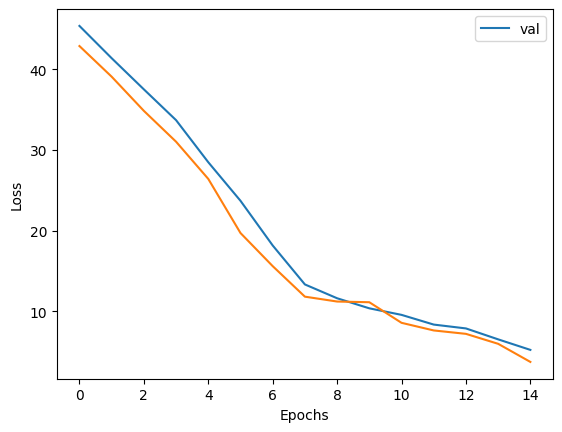

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 4
Epoch n0




2it [00:00, 14.44it/s]

4it [00:00, 14.03it/s]

6it [00:00, 13.65it/s]

8it [00:00, 13.97it/s]

10it [00:00, 12.33it/s]

12it [00:00, 12.90it/s]

15it [00:01, 12.86it/s]


2it [00:00, 46.71it/s][A

  7%|▋         | 1/15 [00:01<00:17,  1.22s/it]

0it [00:00, ?it/s]

2it [00:00, 15.17it/s]

TOTAL TRAIN LOSS 46.5406748453776
TOTAL EVAL LOSS 44.14799928665161
TRAIN 	1.1676218509674072 secs
TRAIN accuracy : 0.0
EVAL 	0.04390406608581543 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 14.42it/s]

6it [00:00, 13.83it/s]

8it [00:00, 14.01it/s]

10it [00:00, 12.36it/s]

12it [00:00, 12.95it/s]

15it [00:01, 12.85it/s]


2it [00:00, 45.73it/s][A

 13%|█▎        | 2/15 [00:02<00:15,  1.22s/it]

0it [00:00, ?it/s]

2it [00:00, 15.73it/s]

TOTAL TRAIN LOSS 42.216795444488525
TOTAL EVAL LOSS 39.612571001052856
TRAIN 	1.1680340766906738 secs
TRAIN accuracy : 0.0
EVAL 	0.04474496841430664 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 14.92it/s]

6it [00:00, 14.78it/s]

8it [00:00, 15.05it/s]

10it [00:00, 13.10it/s]

12it [00:00, 13.91it/s]

15it [00:01, 13.73it/s]


2it [00:00, 50.84it/s][A

 20%|██        | 3/15 [00:03<00:14,  1.19s/it]

0it [00:00, ?it/s]

2it [00:00, 17.45it/s]

TOTAL TRAIN LOSS 38.154002825419106
TOTAL EVAL LOSS 36.045124530792236
TRAIN 	1.0936331748962402 secs
TRAIN accuracy : 0.007481296758104738
EVAL 	0.04033493995666504 secs
EVAL accuracy : 0.011441647597254004


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 16.33it/s]

6it [00:00, 15.69it/s]

8it [00:00, 15.92it/s]

10it [00:00, 13.62it/s]

12it [00:00, 14.06it/s]

15it [00:01, 13.93it/s]


2it [00:00, 49.35it/s][A

 27%|██▋       | 4/15 [00:04<00:12,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 15.41it/s]

TOTAL TRAIN LOSS 33.70700661341349
TOTAL EVAL LOSS 31.784313917160034
TRAIN 	1.0780820846557617 secs
TRAIN accuracy : 0.04987531172069826
EVAL 	0.04146385192871094 secs
EVAL accuracy : 0.029748283752860413


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 14.83it/s]

6it [00:00, 14.67it/s]

8it [00:00, 15.03it/s]

10it [00:00, 13.17it/s]

12it [00:00, 14.04it/s]

15it [00:01, 13.88it/s]


2it [00:00, 52.97it/s][A

 33%|███▎      | 5/15 [00:05<00:11,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 17.24it/s]

TOTAL TRAIN LOSS 28.986696402231853
TOTAL EVAL LOSS 26.642314195632935
TRAIN 	1.0815057754516602 secs
TRAIN accuracy : 0.08229426433915212
EVAL 	0.03869199752807617 secs
EVAL accuracy : 0.09153318077803203


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 15.97it/s]

6it [00:00, 15.39it/s]

8it [00:00, 15.62it/s]

10it [00:00, 13.48it/s]

12it [00:00, 14.33it/s]

15it [00:01, 14.04it/s]


2it [00:00, 51.48it/s][A

 40%|████      | 6/15 [00:06<00:10,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 17.05it/s]

TOTAL TRAIN LOSS 23.611817359924316
TOTAL EVAL LOSS 20.667216181755066
TRAIN 	1.0689280033111572 secs
TRAIN accuracy : 0.09226932668329177
EVAL 	0.03994607925415039 secs
EVAL accuracy : 0.09382151029748284


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 16.23it/s]

6it [00:00, 15.61it/s]

8it [00:00, 15.74it/s]

10it [00:00, 13.52it/s]

12it [00:00, 14.29it/s]

15it [00:01, 14.10it/s]


2it [00:00, 50.80it/s][A

 47%|████▋     | 7/15 [00:08<00:09,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 17.36it/s]

TOTAL TRAIN LOSS 17.123356183369953
TOTAL EVAL LOSS 15.728827714920044
TRAIN 	1.0645191669464111 secs
TRAIN accuracy : 0.11221945137157108
EVAL 	0.040284156799316406 secs
EVAL accuracy : 0.09382151029748284


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 16.43it/s]

6it [00:00, 15.76it/s]

8it [00:00, 15.87it/s]

10it [00:00, 13.45it/s]

12it [00:00, 14.29it/s]

15it [00:01, 14.06it/s]


2it [00:00, 50.84it/s][A

 53%|█████▎    | 8/15 [00:09<00:07,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 17.28it/s]

TOTAL TRAIN LOSS 12.495832006136576
TOTAL EVAL LOSS 11.343157291412354
TRAIN 	1.0681171417236328 secs
TRAIN accuracy : 0.12219451371571072
EVAL 	0.04027080535888672 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 16.42it/s]

6it [00:00, 15.75it/s]

8it [00:00, 15.94it/s]

10it [00:00, 13.58it/s]

12it [00:00, 14.38it/s]

15it [00:01, 14.24it/s]


2it [00:00, 49.21it/s][A

 60%|██████    | 9/15 [00:10<00:06,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 16.97it/s]

TOTAL TRAIN LOSS 10.48569087187449
TOTAL EVAL LOSS 10.089646577835083
TRAIN 	1.0545790195465088 secs
TRAIN accuracy : 0.1396508728179551
EVAL 	0.0416719913482666 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 16.21it/s]

6it [00:00, 15.59it/s]

8it [00:00, 15.82it/s]

10it [00:00, 13.61it/s]

12it [00:00, 14.43it/s]

15it [00:01, 14.20it/s]


2it [00:00, 53.08it/s][A

 67%|██████▋   | 10/15 [00:11<00:05,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 17.06it/s]

TOTAL TRAIN LOSS 8.231634120146433
TOTAL EVAL LOSS 7.567747533321381
TRAIN 	1.0573508739471436 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.03868389129638672 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n10




4it [00:00, 16.30it/s]

6it [00:00, 15.62it/s]

8it [00:00, 15.81it/s]

10it [00:00, 13.51it/s]

12it [00:00, 14.27it/s]

15it [00:01, 14.12it/s]


2it [00:00, 52.83it/s][A

 73%|███████▎  | 11/15 [00:12<00:04,  1.11s/it]

0it [00:00, ?it/s]

2it [00:00, 17.04it/s]

TOTAL TRAIN LOSS 6.30589218934377
TOTAL EVAL LOSS 6.45497053861618
TRAIN 	1.0629198551177979 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.03890204429626465 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n11




4it [00:00, 16.28it/s]

6it [00:00, 15.68it/s]

8it [00:00, 15.76it/s]

10it [00:00, 13.45it/s]

12it [00:00, 14.30it/s]

15it [00:01, 14.12it/s]


2it [00:00, 50.08it/s][A

 80%|████████  | 12/15 [00:13<00:03,  1.11s/it]

0it [00:00, ?it/s]

2it [00:00, 15.22it/s]

TOTAL TRAIN LOSS 5.030227373043696
TOTAL EVAL LOSS 3.5998842120170593
TRAIN 	1.0628268718719482 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04089808464050293 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 14.58it/s]

6it [00:00, 13.94it/s]

8it [00:00, 14.05it/s]

10it [00:00, 12.38it/s]

12it [00:00, 13.00it/s]

15it [00:01, 12.97it/s]


2it [00:00, 45.30it/s][A

 87%|████████▋ | 13/15 [00:14<00:02,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 15.26it/s]

TOTAL TRAIN LOSS 3.186966379483541
TOTAL EVAL LOSS 1.2453197687864304
TRAIN 	1.1574852466583252 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.045114755630493164 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n13




4it [00:00, 15.01it/s]

6it [00:00, 14.85it/s]

8it [00:00, 15.24it/s]

10it [00:00, 13.25it/s]

12it [00:00, 14.09it/s]

15it [00:01, 14.08it/s]


2it [00:00, 52.41it/s][A

 93%|█████████▎| 14/15 [00:15<00:01,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 17.51it/s]

TOTAL TRAIN LOSS 1.8559073954820633
TOTAL EVAL LOSS 0.2418014407157898
TRAIN 	1.0662519931793213 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.03913593292236328 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 16.60it/s]

6it [00:00, 15.81it/s]

8it [00:00, 15.94it/s]

10it [00:00, 13.62it/s]

12it [00:00, 14.50it/s]

15it [00:01, 14.29it/s]


2it [00:00, 46.64it/s][A

100%|██████████| 15/15 [00:17<00:00,  1.13s/it]

TOTAL TRAIN LOSS 0.8523758873343468
TOTAL EVAL LOSS 0.07644010707736015
TRAIN 	1.0504469871520996 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04379391670227051 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 


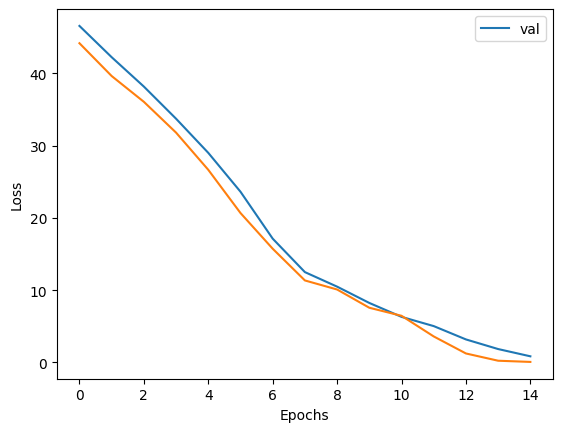

  0%|          | 0/15 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 5
Epoch n0




2it [00:00, 14.85it/s]

4it [00:00, 13.07it/s]

6it [00:00, 11.21it/s]

8it [00:00, 12.01it/s]

10it [00:00, 12.32it/s]

12it [00:01, 12.23it/s]

15it [00:01, 12.44it/s]


2it [00:00, 33.73it/s][A

  7%|▋         | 1/15 [00:01<00:17,  1.27s/it]

0it [00:00, ?it/s]

2it [00:00, 15.19it/s]

TOTAL TRAIN LOSS 45.60235055287679
TOTAL EVAL LOSS 42.96643018722534
TRAIN 	1.206941843032837 secs
TRAIN accuracy : 0.0
EVAL 	0.06037497520446777 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 13.51it/s]

6it [00:00, 12.12it/s]

8it [00:00, 12.94it/s]

10it [00:00, 13.43it/s]

12it [00:00, 13.73it/s]

15it [00:01, 13.88it/s]


2it [00:00, 40.95it/s][A

 13%|█▎        | 2/15 [00:02<00:16,  1.23s/it]

0it [00:00, ?it/s]

2it [00:00, 17.69it/s]

TOTAL TRAIN LOSS 40.906282583872475
TOTAL EVAL LOSS 38.23646783828735
TRAIN 	1.0812149047851562 secs
TRAIN accuracy : 0.031496062992125984
EVAL 	0.04990792274475098 secs
EVAL accuracy : 0.05042016806722689


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 15.04it/s]

6it [00:00, 13.20it/s]

8it [00:00, 14.01it/s]

10it [00:00, 14.38it/s]

12it [00:00, 14.43it/s]

15it [00:01, 14.64it/s]


2it [00:00, 44.58it/s][A

 20%|██        | 3/15 [00:03<00:14,  1.19s/it]

0it [00:00, ?it/s]

2it [00:00, 17.89it/s]

TOTAL TRAIN LOSS 36.18089358011881
TOTAL EVAL LOSS 33.08606266975403
TRAIN 	1.0252289772033691 secs
TRAIN accuracy : 0.08661417322834646
EVAL 	0.045781850814819336 secs
EVAL accuracy : 0.09243697478991597


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 15.14it/s]

6it [00:00, 13.19it/s]

8it [00:00, 13.91it/s]

10it [00:00, 14.24it/s]

12it [00:00, 14.22it/s]

15it [00:01, 14.41it/s]


2it [00:00, 43.22it/s][A

 27%|██▋       | 4/15 [00:04<00:12,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 17.56it/s]

TOTAL TRAIN LOSS 31.286812782287598
TOTAL EVAL LOSS 27.493202686309814
TRAIN 	1.041961908340454 secs
TRAIN accuracy : 0.11023622047244094
EVAL 	0.04716062545776367 secs
EVAL accuracy : 0.10084033613445378


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 15.04it/s]

6it [00:00, 13.10it/s]

8it [00:00, 13.67it/s]

10it [00:00, 14.04it/s]

12it [00:00, 14.09it/s]

15it [00:01, 14.35it/s]


2it [00:00, 40.03it/s][A

 33%|███▎      | 5/15 [00:05<00:11,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 17.66it/s]

TOTAL TRAIN LOSS 26.159668286641438
TOTAL EVAL LOSS 20.016591548919678
TRAIN 	1.0459260940551758 secs
TRAIN accuracy : 0.11286089238845144
EVAL 	0.05089116096496582 secs
EVAL accuracy : 0.11596638655462185


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 14.96it/s]

6it [00:00, 13.06it/s]

8it [00:00, 13.83it/s]

10it [00:00, 14.22it/s]

12it [00:00, 14.31it/s]

15it [00:01, 14.42it/s]


2it [00:00, 40.98it/s][A

 40%|████      | 6/15 [00:06<00:10,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 15.00it/s]

TOTAL TRAIN LOSS 20.23859389623006
TOTAL EVAL LOSS 16.068782210350037
TRAIN 	1.041382074356079 secs
TRAIN accuracy : 0.10498687664041995
EVAL 	0.049748897552490234 secs
EVAL accuracy : 0.10588235294117647


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 13.10it/s]

6it [00:00, 11.85it/s]

8it [00:00, 12.82it/s]

10it [00:00, 13.47it/s]

12it [00:00, 13.73it/s]

15it [00:01, 13.80it/s]


2it [00:00, 41.05it/s][A

 47%|████▋     | 7/15 [00:07<00:09,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 17.36it/s]

TOTAL TRAIN LOSS 15.551610469818115
TOTAL EVAL LOSS 11.666471362113953
TRAIN 	1.0878159999847412 secs
TRAIN accuracy : 0.09711286089238845
EVAL 	0.04965710639953613 secs
EVAL accuracy : 0.11596638655462185


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 14.76it/s]

6it [00:00, 12.94it/s]

8it [00:00, 13.71it/s]

10it [00:00, 14.03it/s]

12it [00:00, 14.06it/s]

15it [00:01, 14.25it/s]


2it [00:00, 40.48it/s][A

 53%|█████▎    | 8/15 [00:09<00:07,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 17.24it/s]

TOTAL TRAIN LOSS 12.726591110229492
TOTAL EVAL LOSS 11.23888075351715
TRAIN 	1.0533781051635742 secs
TRAIN accuracy : 0.11811023622047244
EVAL 	0.050360918045043945 secs
EVAL accuracy : 0.11092436974789915


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 14.64it/s]

6it [00:00, 12.87it/s]

8it [00:00, 13.20it/s]

10it [00:00, 13.29it/s]

12it [00:00, 13.58it/s]

15it [00:01, 13.83it/s]


2it [00:00, 42.58it/s][A

 60%|██████    | 9/15 [00:10<00:06,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 17.26it/s]

TOTAL TRAIN LOSS 11.369786183039347
TOTAL EVAL LOSS 10.389029383659363
TRAIN 	1.0857930183410645 secs
TRAIN accuracy : 0.14173228346456693
EVAL 	0.04786825180053711 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 14.67it/s]

6it [00:00, 12.92it/s]

8it [00:00, 13.62it/s]

10it [00:00, 13.87it/s]

12it [00:00, 13.92it/s]

15it [00:01, 14.14it/s]


2it [00:00, 41.26it/s][A

 67%|██████▋   | 10/15 [00:11<00:05,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 16.95it/s]

TOTAL TRAIN LOSS 10.570560892422995
TOTAL EVAL LOSS 8.294371366500854
TRAIN 	1.0618679523468018 secs
TRAIN accuracy : 0.14698162729658792
EVAL 	0.049391984939575195 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n10




4it [00:00, 14.67it/s]

6it [00:00, 12.90it/s]

8it [00:00, 13.57it/s]

10it [00:00, 13.86it/s]

12it [00:00, 13.98it/s]

15it [00:01, 14.14it/s]


2it [00:00, 42.13it/s][A

 73%|███████▎  | 11/15 [00:12<00:04,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 15.41it/s]

TOTAL TRAIN LOSS 9.587987899780273
TOTAL EVAL LOSS 9.230570495128632
TRAIN 	1.0613350868225098 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.04848003387451172 secs
EVAL accuracy : 0.1495798319327731


Epoch n11




4it [00:00, 13.24it/s]

6it [00:00, 11.80it/s]

8it [00:00, 12.39it/s]

10it [00:00, 12.62it/s]

12it [00:01, 12.51it/s]

15it [00:01, 12.69it/s]


2it [00:00, 35.16it/s][A

 80%|████████  | 12/15 [00:13<00:03,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 15.51it/s]

TOTAL TRAIN LOSS 9.004602948824564
TOTAL EVAL LOSS 7.599209249019623
TRAIN 	1.1829330921173096 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05779671669006348 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 13.31it/s]

6it [00:00, 11.90it/s]

8it [00:00, 12.41it/s]

10it [00:00, 12.71it/s]

12it [00:00, 12.93it/s]

15it [00:01, 13.21it/s]


2it [00:00, 43.75it/s][A

 87%|████████▋ | 13/15 [00:14<00:02,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 17.63it/s]

TOTAL TRAIN LOSS 8.595604876677195
TOTAL EVAL LOSS 8.797267973423004
TRAIN 	1.1364071369171143 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.04683089256286621 secs
EVAL accuracy : 0.1495798319327731


Epoch n13




4it [00:00, 14.85it/s]

6it [00:00, 13.04it/s]

8it [00:00, 13.65it/s]

10it [00:00, 14.02it/s]

12it [00:00, 13.93it/s]

15it [00:01, 14.14it/s]


2it [00:00, 40.95it/s][A

 93%|█████████▎| 14/15 [00:15<00:01,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 17.34it/s]

TOTAL TRAIN LOSS 7.670907119909923
TOTAL EVAL LOSS 7.0390114188194275
TRAIN 	1.061476707458496 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.04997611045837402 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 14.75it/s]

6it [00:00, 12.94it/s]

8it [00:00, 13.60it/s]

10it [00:00, 13.92it/s]

12it [00:00, 13.87it/s]

15it [00:01, 14.11it/s]


2it [00:00, 38.89it/s][A

100%|██████████| 15/15 [00:17<00:00,  1.14s/it]

TOTAL TRAIN LOSS 6.7514041264851885
TOTAL EVAL LOSS 5.251863449811935
TRAIN 	1.064359188079834 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05233883857727051 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 


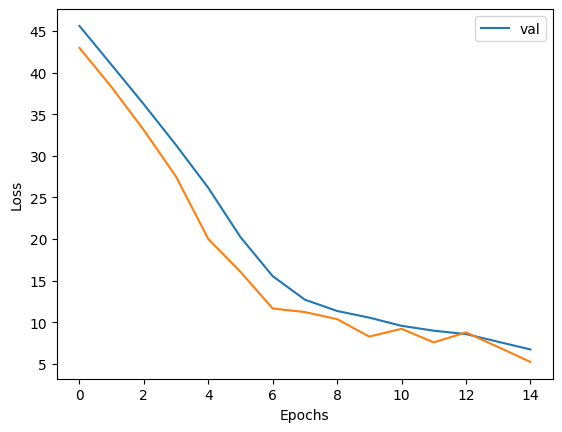

100%|██████████| 5/5 [01:24<00:00, 16.95s/it]


In [21]:
df = experiment(num_experiments=5)

In [22]:
df

,Experiment,Model,Metric,Score
0,1,GT_BERT,Val Accuracy,0.147992
1,1,GT_BERT,Train Loss,1.602460
2,1,GT_BERT,Val Loss,0.227427
3,1,GT_BERT,Train Time,1.074423
4,1,GT_BERT,Val Time,0.045204
5,2,GT_BERT,Val Accuracy,0.149635
6,2,GT_BERT,Train Loss,0.615337
7,2,GT_BERT,Val Loss,0.029641
8,2,GT_BERT,Train Time,1.098616
9,2,GT_BERT,Val Time,0.043270


In [23]:
# Group by Model and Metric and calculate average and standard deviation
result_df = df.groupby(['Model', 'Metric']).agg({'Score': ['mean', 'std']}).reset_index()

# Rename columns for clarity
result_df.columns = ['Model', 'Metric', 'Average Score', 'Standard Deviation']

result_df['Average Score'] = result_df['Average Score'].round(2)
result_df['Standard Deviation'] = result_df['Standard Deviation'].round(2)

# save the result
result_df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_1_global.csv')

In [24]:
 # print results
result_df

,Model,Metric,Average Score,Standard Deviation
0,GT_BERT,Train Loss,3.01,2.80
1,GT_BERT,Train Time,1.08,0.02
2,GT_BERT,Val Accuracy,0.15,0.00
3,GT_BERT,Val Loss,1.87,2.46
4,GT_BERT,Val Time,0.05,0.01
